In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import random

!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import StandardScaler






# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat

     |████████████████████████████████| 82 kB 84 kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2022-02-21 09:52:00--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0s      

2022-02-21 09:52:00 (67.9 MB/s) - ‘visualization.py’ saved [13008/13008]



# Mounting Google Drive

In [2]:
# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

from functools import partial

mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'ML_Project/nn-model/final/'

Mounted at /content/gdrive


Importing the Dataset

In [3]:
path = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_exp.csv" # path for the preprocessed datadet
!wget $path

--2022-02-21 09:56:40--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_exp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3924758 (3.7M) [text/plain]
Saving to: ‘dataset_cleaned_exp.csv’

dataset_cleaned_exp 100%[===================>]   3.74M  --.-KB/s    in 0.07s   

2022-02-21 09:56:41 (57.2 MB/s) - ‘dataset_cleaned_exp.csv’ saved [3924758/3924758]



In [5]:
df = pd.read_csv("dataset_cleaned_exp.csv", index_col="PROC_TRACEINFO")
df.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value_exp,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,results
PROC_TRACEINFO,,,,,,,,,,,,,,
I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,460468.625050,12.16,1,11.97,6.62,26.37,18.8,109.62,6.60,0
I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,498819.706587,12.19,0,11.97,6.41,21.03,18.5,105.48,6.40,0
I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,384615.725794,12.24,1,11.97,6.62,25.81,17.5,100.03,6.61,0
I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,369534.727474,12.35,0,11.97,6.62,24.62,15.6,104.94,6.61,0
I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,474491.982426,12.19,1,11.97,6.62,29.22,33.6,99.19,6.61,0


In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

features = list(df.columns)[:-1]

X_train = df_train[features]
X_test = df_test[features]
y_train = df_train["results"]
y_test = df_test["results"]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test=scaler.transform(X_test)


Only 0.9% of our dataset is labeled as failure. So, an idea is to use SMOTE (Synthetic Minority Over-sampling Technique) to have classes that are more balanced.

In [7]:
smote = SMOTE()

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)


0    27374
1    27374
Name: results, dtype: int64

#Build a NN model
The following function creates a neural network architecture and compiles it

In [ ]:
def make_sequential_model(sample_size, layer_sizes, 
                          hidden_activation_function="relu", 
                          out_activation_function="softmax",
                          loss_fun="categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of 
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"/"selu"/"tanh"/"elu"/

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"/"softplus"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying 
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0], 
                  input_dim = sample_size) )
  
  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )
    
  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )
  

  model.compile(loss=loss_fun, 
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)
  
  return model

In [10]:
##Here is the definition of the model we should keep 2 at the end of the shallow structrure since true or false
sample_size=X_train_balanced.shape[1]## we use 13 metrics
shallow_architecture = [8, 6, 2]



In [ ]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

## Training

In [ ]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000, 
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training 
            (thanks to the ModelCheckpoint callback (see the implementation 
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.
  
  overwrite: boolean
            If true, the model will be built and trained from scratch, 
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the 
            specified number of epochs
  """
  
  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor 
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the 
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of 
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True) 


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb], 
                      validation_split=0.2 )

  return history

In [11]:

data=pd.DataFrame({'label':y_train_balanced})
datatest=pd.DataFrame({'label':y_test})
one_hot_encoder = ce.OneHotEncoder(cols=['label'], use_cat_names='True')
one_hot_encoder.fit(data)
y_train1 = one_hot_encoder.transform(data)
y_test1=one_hot_encoder.transform(datatest)

print('y_train', y_train1.head(n=40))

num_of_classes = y_train1.shape[1]
class_names =list(y_train1.columns)
print('There are ', num_of_classes, ' classes. Their names is:', class_names)



y_train     label_0.0  label_1.0
0           1          0
1           1          0
2           1          0
3           1          0
4           1          0
5           1          0
6           1          0
7           1          0
8           1          0
9           1          0
10          1          0
11          1          0
12          1          0
13          1          0
14          1          0
15          1          0
16          1          0
17          1          0
18          1          0
19          1          0
20          1          0
21          1          0
22          1          0
23          1          0
24          1          0
25          1          0
26          1          0
27          1          0
28          1          0
29          1          0
30          1          0
31          1          0
32          0          1
33          1          0
34          1          0
35          1          0
36          1          0
37          1          0
38          1    

In [ ]:
def buildmodel(learning_rate):
  model = make_sequential_model(sample_size, shallow_architecture, 
                              learning_rate=0.001)
  nn_file = my_path + 'nn-'+str(learning_rate)+'.h5'
  model.summary

  history = train_model(model, nn_file, X_train_balanced, y_train1, seed=5, max_epochs=200)


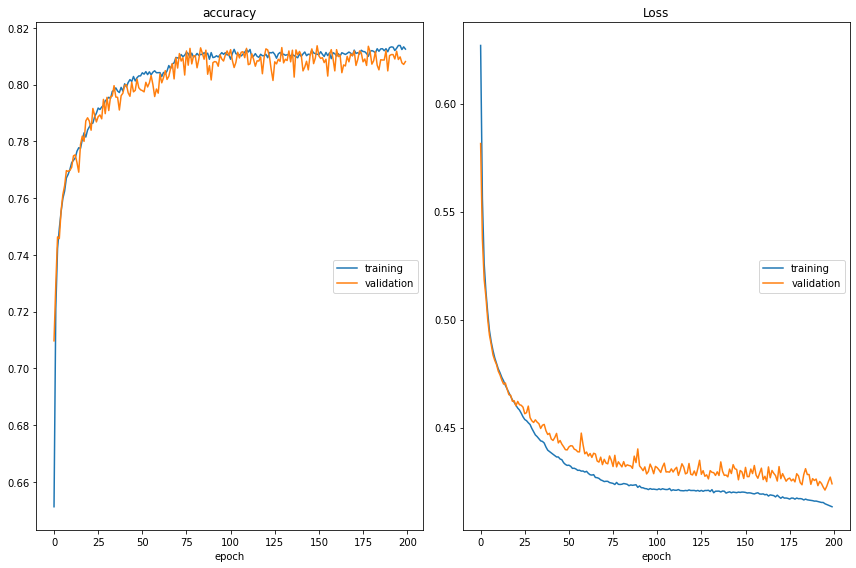

accuracy
	training         	 (min:    0.651, max:    0.814, cur:    0.813)
	validation       	 (min:    0.710, max:    0.814, cur:    0.808)
Loss
	training         	 (min:    0.413, max:    0.627, cur:    0.413)
	validation       	 (min:    0.421, max:    0.581, cur:    0.424)
1369/1369 [==============================] - 6s 4ms/step - loss: 0.4134 - accuracy: 0.8125 - val_loss: 0.4240 - val_accuracy: 0.8081


In [ ]:
buildmodel(0.1)

It looks like we have a good model for 0.1. Let's try with a smaller one:0.01.



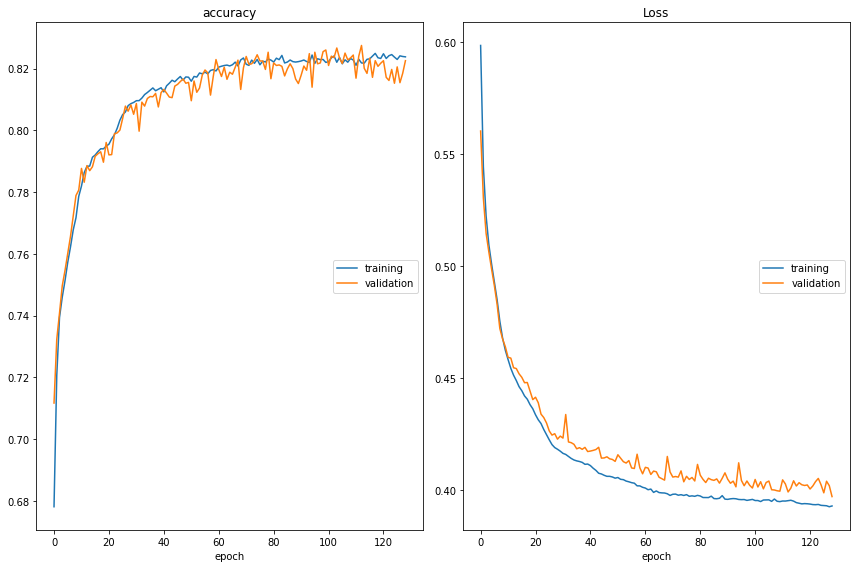

accuracy
	training         	 (min:    0.678, max:    0.825, cur:    0.824)
	validation       	 (min:    0.712, max:    0.827, cur:    0.823)
Loss
	training         	 (min:    0.392, max:    0.599, cur:    0.393)
	validation       	 (min:    0.397, max:    0.560, cur:    0.397)
1369/1369 [==============================] - 6s 5ms/step - loss: 0.3928 - accuracy: 0.8238 - val_loss: 0.3970 - val_accuracy: 0.8226
Epoch 130/200
1359/1369 [============================>.] - ETA: 0s - loss: 0.3927 - accuracy: 0.8239

KeyboardInterrupt: ignored

In [ ]:
buildmodel(0.01)

This one stopped at 97 epochs. Lets try with a smaller one : 0.001


In [ ]:
buildmodel(0.001)

Also stopped at 97 lets try smaller : 0.0001

In [ ]:
buildmodel(0.0001)

0,1 seems to be the best

#Prediction

In [ ]:
nn_file = my_path + 'nn-wide2-lr_0.01.h5'
model = load_model(nn_file)

Probabilty of each sampple from the test to be in each class

In [ ]:
y_proba = model.predict(X_test)
print( 'y_proba\n', y_proba)

y_proba
 [[0.48722282 0.51277715]
 [0.48722282 0.51277715]
 [0.48722282 0.51277715]
 ...
 [0.4872228  0.51277715]
 [0.4872228  0.51277715]
 [0.4872228  0.51277715]]


Predicted class of each sample


In [ ]:
pred_label =np.argmax(model.predict(X_test), axis=-1)
print( 'pred_label\n', pred_label )

pred_label
 [1 1 1 ... 1 1 1]


In [ ]:
true_label = np.argmax(y_test1.values,axis=1)
true_label


array([0, 0, 0, ..., 0, 0, 0])

Confusion matrix, without normalization
[[   0 6836]
 [   0   67]]


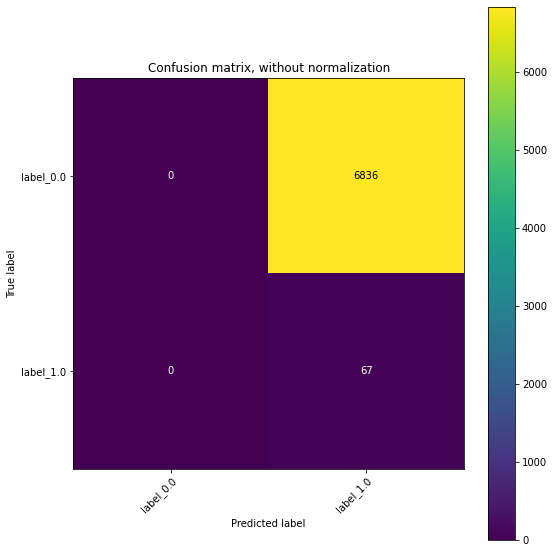

In [ ]:
plot_conf_mat(true_label, pred_label, np.array(class_names),normalize=False )


In [ ]:
print("The names of the classes are ", class_names)
print("The true classes found in the test set are ", Counter(true_label) )
print("The predicted classes are ", Counter(pred_label) )

The names of the classes are  ['label_0.0', 'label_1.0']
The true classes found in the test set are  Counter({0: 6836, 1: 67})
The predicted classes are  Counter({1: 6903})


In [ ]:
print( classification_report(true_label, pred_label, labels=[0,1],
                             target_names=class_names) )

              precision    recall  f1-score   support

   label_0.0       0.00      0.00      0.00      6836
   label_1.0       0.01      1.00      0.02        67

    accuracy                           0.01      6903
   macro avg       0.00      0.50      0.01      6903
weighted avg       0.00      0.01      0.00      6903



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We see that the achieved results are not great so lets try with a deeper architecture

# Deeper Network


In [ ]:
deep_architecture = [8, 8 ,8, 8, 8, 8, 8, 8, 8, num_of_classes]


In [ ]:
def makeDeep(learning_rate):
  model = make_sequential_model(sample_size, deep_architecture, 
                              learning_rate=0.01)
  model.summary()
  nn_file = my_path + 'nn-deep-lr_'+str(learning_rate)+'.h5'
  history =  train_model(model, nn_file, X_train_balanced, y_train1, seed=5, max_epochs=300)

Lets try with 0,1

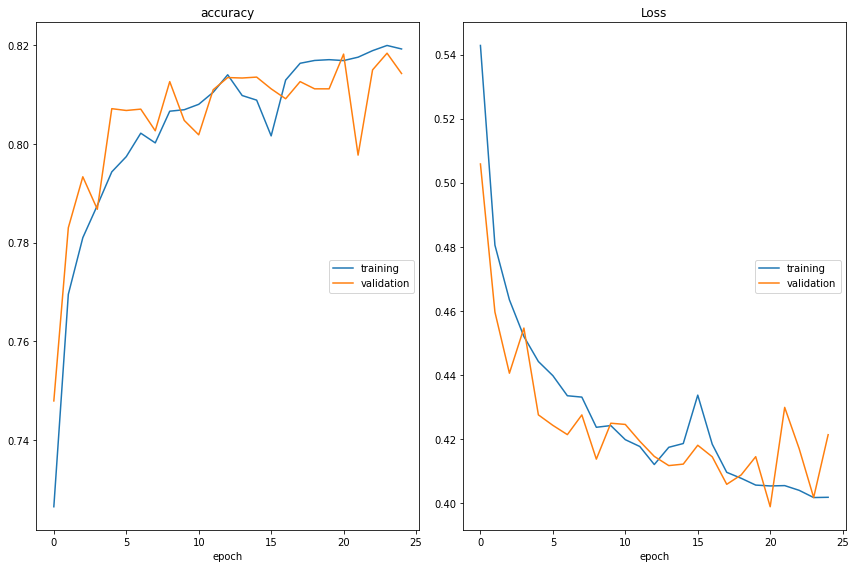

accuracy
	training         	 (min:    0.727, max:    0.820, cur:    0.819)
	validation       	 (min:    0.748, max:    0.818, cur:    0.814)
Loss
	training         	 (min:    0.402, max:    0.543, cur:    0.402)
	validation       	 (min:    0.399, max:    0.506, cur:    0.421)
1369/1369 [==============================] - 8s 6ms/step - loss: 0.4017 - accuracy: 0.8192 - val_loss: 0.4213 - val_accuracy: 0.8142
Epoch 26/300
 904/1369 [==================>...........] - ETA: 1s - loss: 0.4036 - accuracy: 0.8204

KeyboardInterrupt: ignored

In [ ]:
makeDeep(0.1)

Here We stopped early and we lack fitness so lets try with a smaller one

In [ ]:
makeDeep(0.01)

In [ ]:
makeDeep(0.001)

In [ ]:
makeDeep(0.0001)

This model seems inconclusive lets try one with a wide architecture

# Wider Architecture

In [ ]:
wide_architecture = [72, 72,72,num_of_classes]

In [ ]:
wide_architecture = [72, 72,72,num_of_classes]

def makeWide(learning_rate):
  model = make_sequential_model(sample_size, wide_architecture, 
                              learning_rate=0.01)
  model.summary()
  nn_file = my_path + 'nn-wide-lr_'+str(learning_rate)+'.h5'
  history =  train_model(model, nn_file, X_train_balanced, y_train1, seed=5, max_epochs=300)

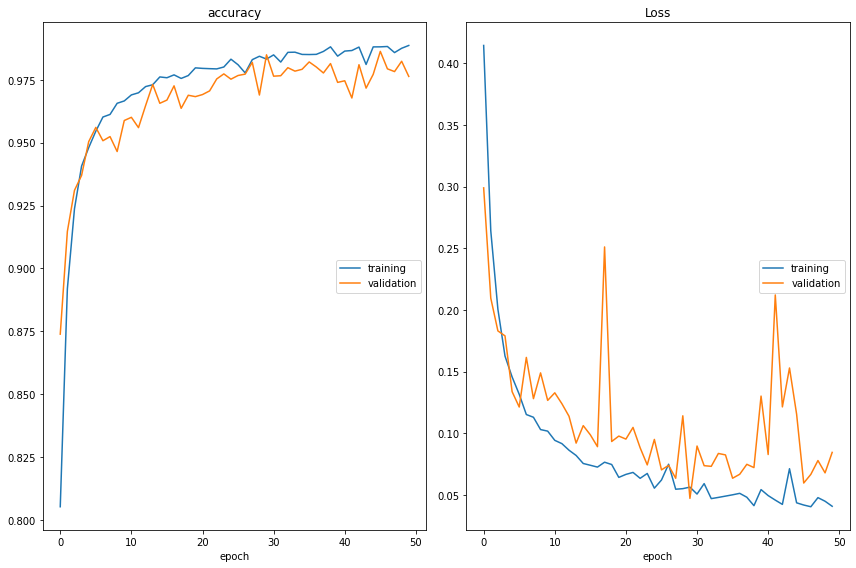

accuracy
	training         	 (min:    0.805, max:    0.989, cur:    0.989)
	validation       	 (min:    0.874, max:    0.986, cur:    0.976)
Loss
	training         	 (min:    0.040, max:    0.414, cur:    0.041)
	validation       	 (min:    0.047, max:    0.299, cur:    0.084)
Restoring model weights from the end of the best epoch: 30.
1369/1369 [==============================] - 7s 5ms/step - loss: 0.0408 - accuracy: 0.9887 - val_loss: 0.0845 - val_accuracy: 0.9763
Epoch 50: early stopping


In [ ]:
makeWide(0.1)

The results seemed impressive lets try with a smaller value

In [ ]:
makeWide(0.001)

In [ ]:
wide2_architecture = [48, 48,48,48,48,48,48,48,48,num_of_classes]

def make2Wide(learning_rate):
  model = make_sequential_model(sample_size, wide2_architecture, 
                              learning_rate=0.01)
  model.summary()
  nn_file = my_path + 'nn-wide2-lr_'+str(learning_rate)+'.h5'
  history =  train_model(model, nn_file, X_train_balanced, y_train1, seed=5, max_epochs=300)

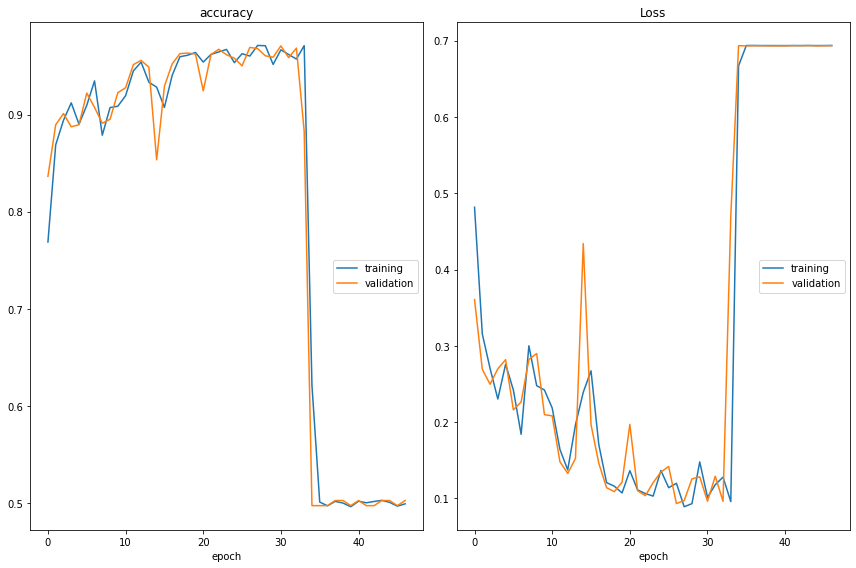

accuracy
	training         	 (min:    0.496, max:    0.971, cur:    0.499)
	validation       	 (min:    0.497, max:    0.971, cur:    0.503)
Loss
	training         	 (min:    0.089, max:    0.694, cur:    0.694)
	validation       	 (min:    0.093, max:    0.694, cur:    0.693)
Restoring model weights from the end of the best epoch: 27.
1369/1369 [==============================] - 8s 6ms/step - loss: 0.6937 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.5026
Epoch 47: early stopping


In [ ]:
make2Wide(0.1)

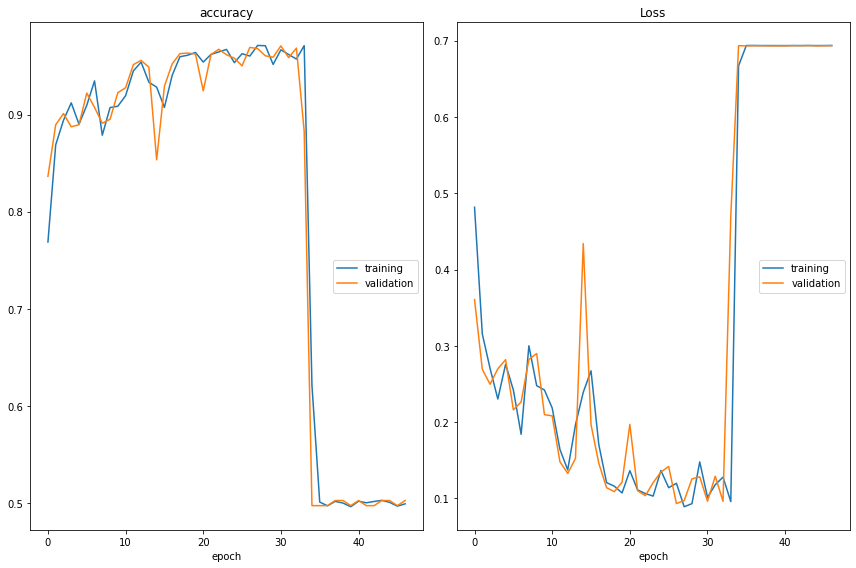

accuracy
	training         	 (min:    0.496, max:    0.971, cur:    0.499)
	validation       	 (min:    0.497, max:    0.971, cur:    0.503)
Loss
	training         	 (min:    0.089, max:    0.694, cur:    0.694)
	validation       	 (min:    0.093, max:    0.694, cur:    0.693)
Restoring model weights from the end of the best epoch: 27.
1369/1369 [==============================] - 8s 6ms/step - loss: 0.6937 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.5026
Epoch 47: early stopping


In [ ]:
make2Wide(0.01)

Seems to be working

## Prediction

In [ ]:
nn_file = my_path + 'nn-wide-lr_0.001.h5'
model = load_model(nn_file)

In [ ]:
y_proba = model.predict(X_test)
print( 'y_proba\n', y_proba)
pred_label =np.argmax(model.predict(X_test), axis=-1)
print( 'pred_label\n', pred_label )
true_label = np.argmax(y_test1.values,axis=1)
true_label

In [ ]:
plot_conf_mat(true_label, pred_label, np.array(class_names), normalize=False )


In [ ]:
print("The names of the classes are ", class_names)
print("The true classes found in the test set are ", Counter(true_label) )
print("The predicted classes are ", Counter(pred_label) )

In [ ]:
accuracy_score(true_label,pred_label)

In [ ]:
print( classification_report(true_label, pred_label, labels=[0,1,2,3,4],
                             target_names=class_names) )

## Many Models



In [ ]:
wide2_architecture = [512,1024,2,1024,512,num_of_classes]
##With relu
def makeArch(learning_rate,architecture):
  model = make_sequential_model(sample_size,architecture, 
                              learning_rate=0.01)
  model.summary()
  nn_file = my_path + 'nn-weird1-lr_.h5'
  history =  train_model(model, nn_file, X_train_balanced, y_train1, seed=5, max_epochs=300)

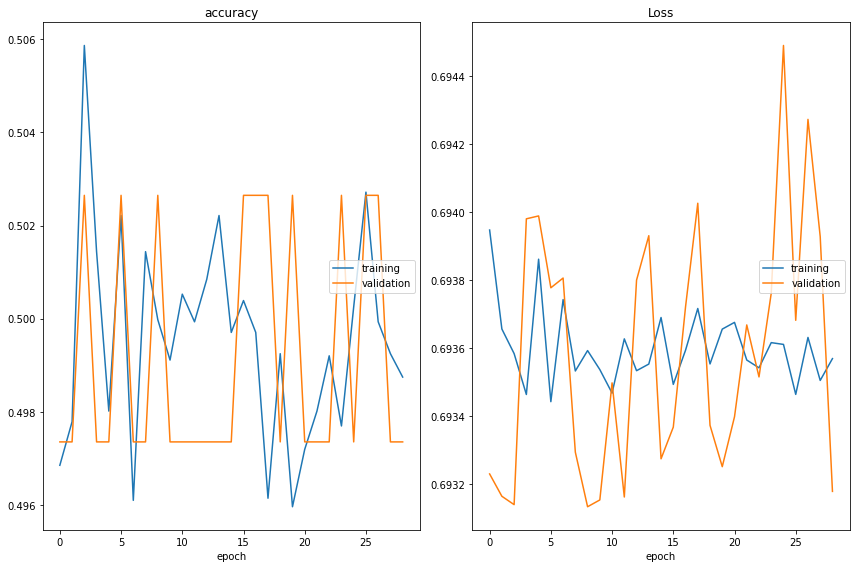

accuracy
	training         	 (min:    0.496, max:    0.506, cur:    0.499)
	validation       	 (min:    0.497, max:    0.503, cur:    0.497)
Loss
	training         	 (min:    0.693, max:    0.694, cur:    0.694)
	validation       	 (min:    0.693, max:    0.694, cur:    0.693)
Restoring model weights from the end of the best epoch: 9.
1369/1369 [==============================] - 30s 22ms/step - loss: 0.6936 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.4974
Epoch 29: early stopping


In [ ]:
makeArch(0.01,wide2_architecture)

# Semi-Supervised Learning

In [ ]:
npath = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_v2.csv"
!wget $npath



--2022-02-20 13:48:54--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned_v2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3599714 (3.4M) [text/plain]
Saving to: ‘dataset_cleaned_v2.csv’

dataset_cleaned_v2. 100%[===================>]   3.43M  --.-KB/s    in 0.08s   

2022-02-20 13:48:55 (43.2 MB/s) - ‘dataset_cleaned_v2.csv’ saved [3599714/3599714]



In [ ]:
df2 =pd.read_csv("dataset_cleaned_v2.csv", index_col="PROC_TRACEINFO")
df2.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,results
PROC_TRACEINFO,,,,,,,,,,,,,,
I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,-1.00,11.97,6.62,26.37,18.8,109.62,6.60,0
I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,0
I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,-1.00,11.97,6.62,25.81,17.5,100.03,6.61,0
I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61,0
I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,-1.00,11.97,6.62,29.22,33.6,99.19,6.61,0


In [ ]:
## we scale the data
df2_train, df2_test = train_test_split(df2, test_size=0.2, random_state=1)
features = list(df2.columns)[:-1]
normal_sample=df2_train[df2_train['results'] == 0]
X2_train = normal_sample[features]
X2_test = df2_test[features]
y2_train = df2_train["results"]
y2_test = df2_test["results"]
datatrain2=pd.DataFrame({'label':y2_train})
datatest2=pd.DataFrame({'label':y2_test})
one_hot_encoder = ce.OneHotEncoder(cols=['label'], use_cat_names='True')
one_hot_encoder.fit(datatrain2)
training_df=one_hot_encoder.transform(datatrain2)
testing_df=one_hot_encoder.transform(datatest2)

print('y2_train',training_df.head(n=40))

num_of_classes = training_df.shape[1]
class_names =list(training_df.columns)
print('There are ', num_of_classes, ' classes. Their names is:', class_names)



scaler = StandardScaler()
scaler.fit(X2_train)
X2_train = scaler.transform(X2_train)
X2_test=scaler.transform(X2_test)
sample_size=X2_train.shape[1]## we use 13 metrics
sample_size


y2_train                             label_0.0  label_1.0
PROC_TRACEINFO                                  
I-B-XA1207672-190831-00583          1          0
I-B-XA1207672-190815-01289          1          0
I-B-XA1207672-190904-01214          1          0
I-B-XA1207672-190503-01112          1          0
I-B-XA1207672-190627-01109          1          0
I-B-XA1207672-190424-03179          1          0
I-B-XA1207672-190508-02204          1          0
I-B-XA1207672-190530-03061          1          0
I-B-XA1207672-190802-01808          1          0
I-B-XA1207672-190712-01793          1          0
I-B-XA1207672-190802-02543          1          0
I-B-XA1207672-190520-00876          1          0
I-B-XA1207672-190802-01283          1          0
I-B-XA1207672-190907-01434          1          0
I-B-XA1207672-190503-02212          1          0
I-B-XA1207672-190504-00512          1          0
I-B-XA1207672-190815-00720          1          0
I-B-XA1207672-190828-01333          1          0
I-B-XA12076

13

In [ ]:
##We get all the good engines parameters
goodtraining=training_df[training_df["label_1.0"] == 0]


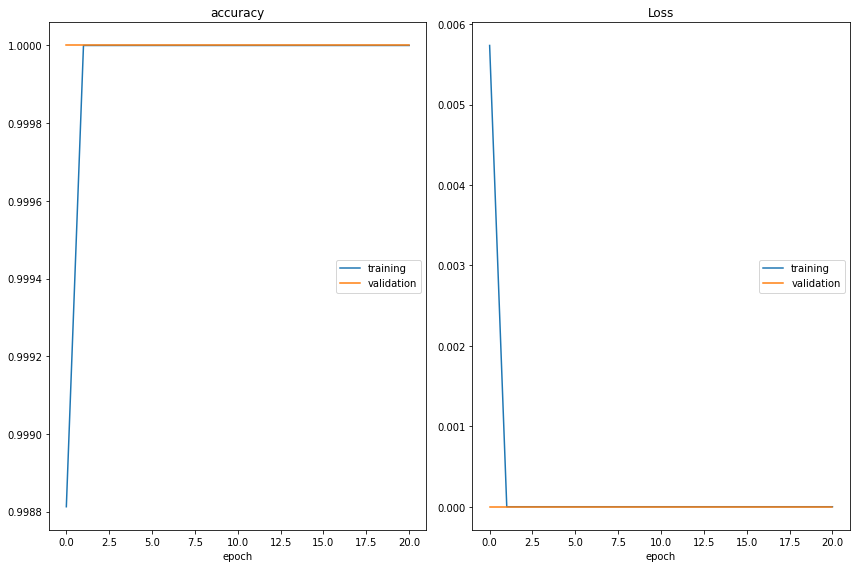

accuracy
	training         	 (min:    0.999, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.006, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/ML_Project/nn-model/nn_semi_0,01/assets
Restoring model weights from the end of the best epoch: 1.
685/685 [==============================] - 5s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 21: early stopping


In [ ]:
model = make_sequential_model(sample_size, [13,26,52,2,52,26,13,2], 
                            learning_rate=0.01)
model.summary()
nn_file = my_path + 'nn_semi_0,01'
history =  train_model(model, nn_file, X2_train, goodtraining, seed=5, max_epochs=300)

# Prediction

In [8]:
##'nn-wide2-lr_0.01.h5'
def predict(file):
  nn_file = my_path + file
  model = load_model(nn_file)
  y_proba = model.predict(X_test)
  pred_label =np.argmax(model.predict(X_test), axis=-1)
  true_label = np.argmax(y_test1.values,axis=1)
  plot_conf_mat(true_label, pred_label, np.array(class_names),normalize=True)
  print("The names of the classes are ", class_names)
  print("The true classes found in the test set are ", Counter(true_label) )
  print("The predicted classes are ", Counter(pred_label) )
  print( classification_report(true_label, pred_label, labels=[0,1],
                             target_names=class_names) )



Normalized confusion matrix
[[0.70874781 0.29125219]
 [0.6119403  0.3880597 ]]
The names of the classes are  ['label_0.0', 'label_1.0']
The true classes found in the test set are  Counter({0: 6836, 1: 67})
The predicted classes are  Counter({0: 4886, 1: 2017})
              precision    recall  f1-score   support

   label_0.0       0.99      0.71      0.83      6836
   label_1.0       0.01      0.39      0.02        67

    accuracy                           0.71      6903
   macro avg       0.50      0.55      0.43      6903
weighted avg       0.98      0.71      0.82      6903



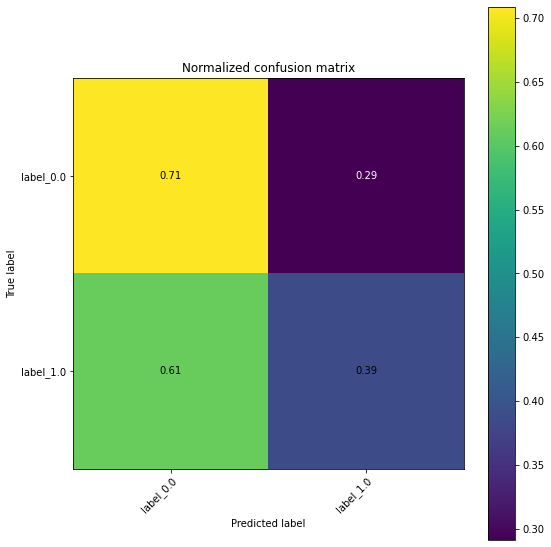

In [12]:
predict('nn-0.1.h5') #Shallow Architecture [8,8,8,8,2]

Normalized confusion matrix
[[0.76916325 0.23083675]
 [0.70149254 0.29850746]]
The names of the classes are  ['label_0.0', 'label_1.0']
The true classes found in the test set are  Counter({0: 6836, 1: 67})
The predicted classes are  Counter({0: 5305, 1: 1598})
              precision    recall  f1-score   support

   label_0.0       0.99      0.77      0.87      6836
   label_1.0       0.01      0.30      0.02        67

    accuracy                           0.76      6903
   macro avg       0.50      0.53      0.45      6903
weighted avg       0.98      0.76      0.86      6903



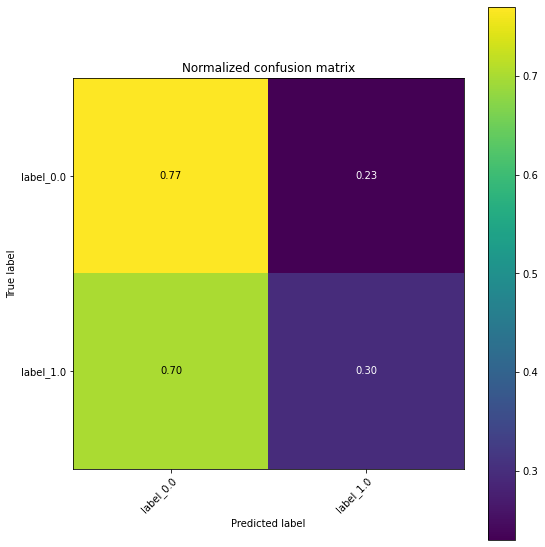

In [13]:
predict('nn-deep-lr_0.1.h5') # deep architecture [8, 8 ,8, 8, 8, 8, 8, 8, 8, 2]


Normalized confusion matrix
[[0.95231129 0.04768871]
 [0.97014925 0.02985075]]
The names of the classes are  ['label_0.0', 'label_1.0']
The true classes found in the test set are  Counter({0: 6836, 1: 67})
The predicted classes are  Counter({0: 6575, 1: 328})
              precision    recall  f1-score   support

   label_0.0       0.99      0.95      0.97      6836
   label_1.0       0.01      0.03      0.01        67

    accuracy                           0.94      6903
   macro avg       0.50      0.49      0.49      6903
weighted avg       0.98      0.94      0.96      6903



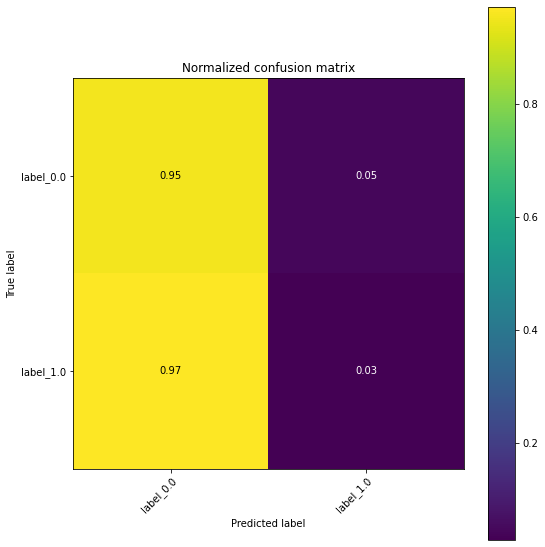

In [14]:
predict('nn-wide-lr_0.1.h5') #Wide [72, 72,72,2]

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]
The names of the classes are  ['label_0.0', 'label_1.0']
The true classes found in the test set are  Counter({0: 6836, 1: 67})
The predicted classes are  Counter({1: 6903})
              precision    recall  f1-score   support

   label_0.0       0.00      0.00      0.00      6836
   label_1.0       0.01      1.00      0.02        67

    accuracy                           0.01      6903
   macro avg       0.00      0.50      0.01      6903
weighted avg       0.00      0.01      0.00      6903



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


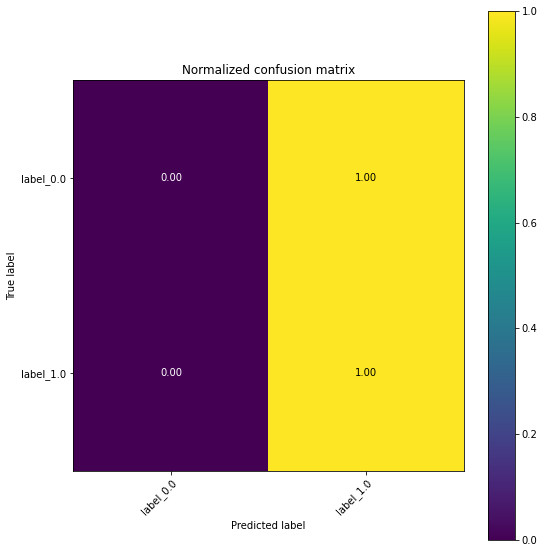

In [15]:
predict('nn-wide2-lr_0.01.h5') #Hybrid [48,48,48,48,48,48,48,48,48,2]
